In [56]:
import numpy as np
import matplotlib.pyplot as plt
import eleanor
import lightkurve as lk
import copy
import tensorflow as tf
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
eleanor.__file__

'/Users/adityasengupta/projects/pals/onlinetessscience/eleanor/eleanor/__init__.py'

In [3]:
star = eleanor.Source(tic=120362128, sector=14, tc=True)

In [4]:
data = eleanor.TargetData(star, height=15, width=15, do_pca=True, do_psf=True)



100%|██████████| 1241/1241 [00:41<00:00, 30.18it/s]


In [5]:
sc = lk.search_targetpixelfile(target='tic120362128', sector=14).download()
sq = sc.quality < 5000
start = 2500
end = 3400

In [7]:
data_m = copy.deepcopy(data)
data_z = copy.deepcopy(data)
data.psf_lightcurve(data_arr = sc.flux[sq][start:end], err_arr = sc.flux_err[sq][start:end], 
                        bkg_arr=sc.flux_bkg[sq,0,0][start:end], verbose=True, nstars=3, xc=[4.9, 4.5, 4.7], 
                        yc=[3.0, 4.4, 7.0], ignore_pixels=1)
data_m.psf_lightcurve(data_arr = sc.flux[sq][start:end], err_arr = sc.flux_err[sq][start:end], 
                        bkg_arr=sc.flux_bkg[sq,0,0][start:end], verbose=True, nstars=3, model='moffat', xc=[4.9, 4.5, 4.7],
                        yc=[3.0, 4.4, 7.0], ignore_pixels=1)

100%|██████████| 900/900 [01:02<00:00, 14.39it/s]


In [77]:
data_z.psf_lightcurve(data_arr = sc.flux[sq][start:end], err_arr = sc.flux_err[sq][start:end], 
                        bkg_arr=sc.flux_bkg[sq,0,0][start:end], verbose=True, nstars=3, model='zernike', xc=[4.9, 4.5, 4.7], yc=[3.0, 4.4, 7.0], ignore_pixels=1)

100%|██████████| 900/900 [17:38<00:00,  1.18s/it]


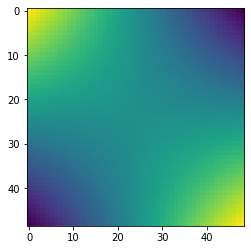

In [76]:

sess = tf.Session()
s = 49
zern = eleanor.models.Zernike((s,s),0,0)
x, y = zern.x - np.median(zern.x), zern.y - np.median(zern.y)
plt.imshow(zern.zernike(3).eval(session=sess) * (x ** 2 + y ** 2 < (s//2) ** 2))

[autoreload of eleanor.models failed: Traceback (most recent call last):
  File "/Users/adityasengupta/opt/anaconda3/envs/ots/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/adityasengupta/opt/anaconda3/envs/ots/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/adityasengupta/opt/anaconda3/envs/ots/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/adityasengupta/opt/anaconda3/envs/ots/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen imp

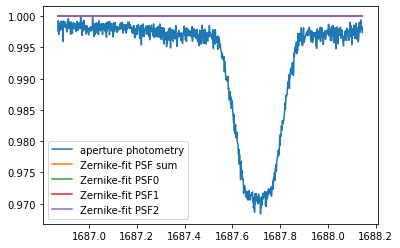

In [78]:
time = sc.time[sq][start:end]
photometry_flux = sc.to_lightcurve().flux[sq][start:end]
psf_flux = np.sum(data_z.all_psf, axis=1)
# plt.plot(sc.time[sq][start:end], psf_flux / np.max(psf_flux), label='Gaussian-fit PSF')
plt.plot(time, photometry_flux / np.max(photometry_flux), label='aperture photometry')
plt.plot(time, psf_flux / np.max(psf_flux), label='Zernike-fit PSF sum')
for i in range(3):
    plt.plot(time, data_z.all_psf[:,i] / np.max(data_z.all_psf[:,i]), label='Zernike-fit PSF' + str(i))
plt.legend()

In [26]:
print(lk.estimate_cdpp(photometry_flux, transit_duration=1))
print(lk.estimate_cdpp(psf_flux, transit_duration=1))

766.824152995914
0.0
